### ValueInvestor




**Background:**


We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.


Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.


**Data Description:**


You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data


**DownloadData:** https://docs.google.com/spreadsheets/d/1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk/edit#gid=299024346


**Goal(s):**


Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.


**Success Metrics:**


Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math

from helper_function import plot_predictions, get_bollinger_df

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Using Russia-Sberbank Rossil PAQ(SBER) dataset

In [3]:

SBER_df =pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx", 0)[:-1]
SBER_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,291.02,294.0,294.42,290.26,47.00M,-0.0076
1,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030


In [4]:
SBER_df["Date"] =pd.to_datetime(SBER_df["Date"])
SBER_df.set_index("Date", inplace=True)
SBER_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294.0,294.42,290.26,47.00M,-0.0076
2021-03-30,293.25,294.86,295.72,291.5,38.81M,-0.0002
2021-03-29,293.3,289.72,294.09,289.26,43.68M,0.0071
2021-03-26,291.22,288.63,292.75,288.32,56.07M,0.0159
2021-03-25,286.66,286.5,287.03,283.85,35.22M,0.0030


In [5]:
SBER_df=SBER_df[["Price"]]
SBER_df =SBER_df.sort_index()
SBER_df =SBER_df.rolling(7).mean().dropna()
SBER_df.head()

,Price
Date,
2020-01-14,257.954286
2020-01-15,258.141429
2020-01-16,258.657143
2020-01-17,259.135714
2020-01-20,260.320000


In [6]:
def Lookback_data(df, lookback):
    data_raw = df.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback + 1])
    data = np.array(data)
    
    X = data [:, :-1, :].reshape(len(data), 5)
    y = data[:, -1, 0].reshape(-1,1)
    
    
    df_featured = pd.DataFrame(X)
    df_featured['y'] = y
    df_featured.set_index(df.index[lookback:], inplace = True)
    return df_featured

In [7]:
SBER_df_featured =Lookback_data(SBER_df,5)
SBER_df_featured.head()

,0,1,2,3,4,y
Date,,,,,,
2020-01-21,257.954286,258.141429,258.657143,259.135714,260.320000,261.730000
2020-01-22,258.141429,258.657143,259.135714,260.320000,261.730000,262.321429
2020-01-23,258.657143,259.135714,260.320000,261.730000,262.321429,262.990000
2020-01-24,259.135714,260.320000,261.730000,262.321429,262.990000,264.301429
2020-01-27,260.320000,261.730000,262.321429,262.990000,264.301429,263.988571


#### Splitting Dataset

In [8]:
train_ratio = 0.7
validation_ratio = 0.1

train_ratio +validation_ratio <= 0.8  # Train + validation ratio shold be less than or equal to 0.8
train_size =int(len(SBER_df_featured) *train_ratio)
val_size =int(len(SBER_df_featured) *validation_ratio)
test_size = len(SBER_df_featured) -train_size-val_size


train, val, test = SBER_df_featured.iloc[0:train_size,:], SBER_df_featured.iloc[train_size: train_size + val_size,:]  ,\
                SBER_df_featured.iloc[train_size+val_size:len(SBER_df_featured),:]


In [9]:
train.shape, test.shape, val.shape

((210, 6), (60, 6), (30, 6))

### Scaling the data 

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


scaler =MinMaxScaler(feature_range=(0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train[train.columns]))
val_scaled =pd.DataFrame(scaler.transform(val[val.columns]))
test_scaled =pd.DataFrame(scaler.transform(test[test.columns]))


train_scaled.columns =["day1","day2", "day3", "day4", "day5", "y"]
val_scaled.columns=["day1","day2", "day3", "day4", "day5", "y"]
test_scaled.columns = ["day1","day2", "day3", "day4", "day5", "y"]

In [11]:
## separting dataset into train, validation & test
# Training
X_train =train_scaled.drop("y", axis=1).values
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train =train_scaled["y"].values

# Validation
X_val =val_scaled.drop("y", axis=1).values
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val =val_scaled["y"].values

# Test
X_test =test_scaled.drop("y", axis=1).values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test =test_scaled["y"].values

### Modeling

In [12]:
from tensorflow.keras.layers import Dense, LSTM, LeakyReLU
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks=[
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, min_delta = 0.00000000001, verbose=1),
    ModelCheckpoint("model.h5", verbose=1, save_best_only=True, save_weights_only=True)
]

In [13]:
model = Sequential()
model.add(LSTM(100,return_sequences=True,activation="relu", input_shape=(5,1)))
model.add(LSTM(100, return_sequences=True, activation="relu"))
model.add(LSTM(100))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 5, 100)            80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train , epochs=100, batch_size= 32, 
         validation_data = (X_val, y_val),
         callbacks=callbacks)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.1955
Epoch 1: val_loss improved from inf to 0.67905, saving model to model.h5
7/7 [==============================] - 6s 432ms/step - loss: 0.1955 - val_loss: 0.6790 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.0862
Epoch 2: val_loss improved from 0.67905 to 0.09796, saving model to model.h5
7/7 [==============================] - 0s 50ms/step - loss: 0.0862 - val_loss: 0.0980 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0524
Epoch 3: val_loss did not improve from 0.09796
7/7 [==============================] - 0s 43ms/step - loss: 0.0524 - val_loss: 0.1049 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.0344
Epoch 4: val_loss did not improve from 0.09796
7/7 [==============================] - 0s 40ms/step - loss: 0.0344 - val_loss: 0.1814 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - ETA: 0s - lo

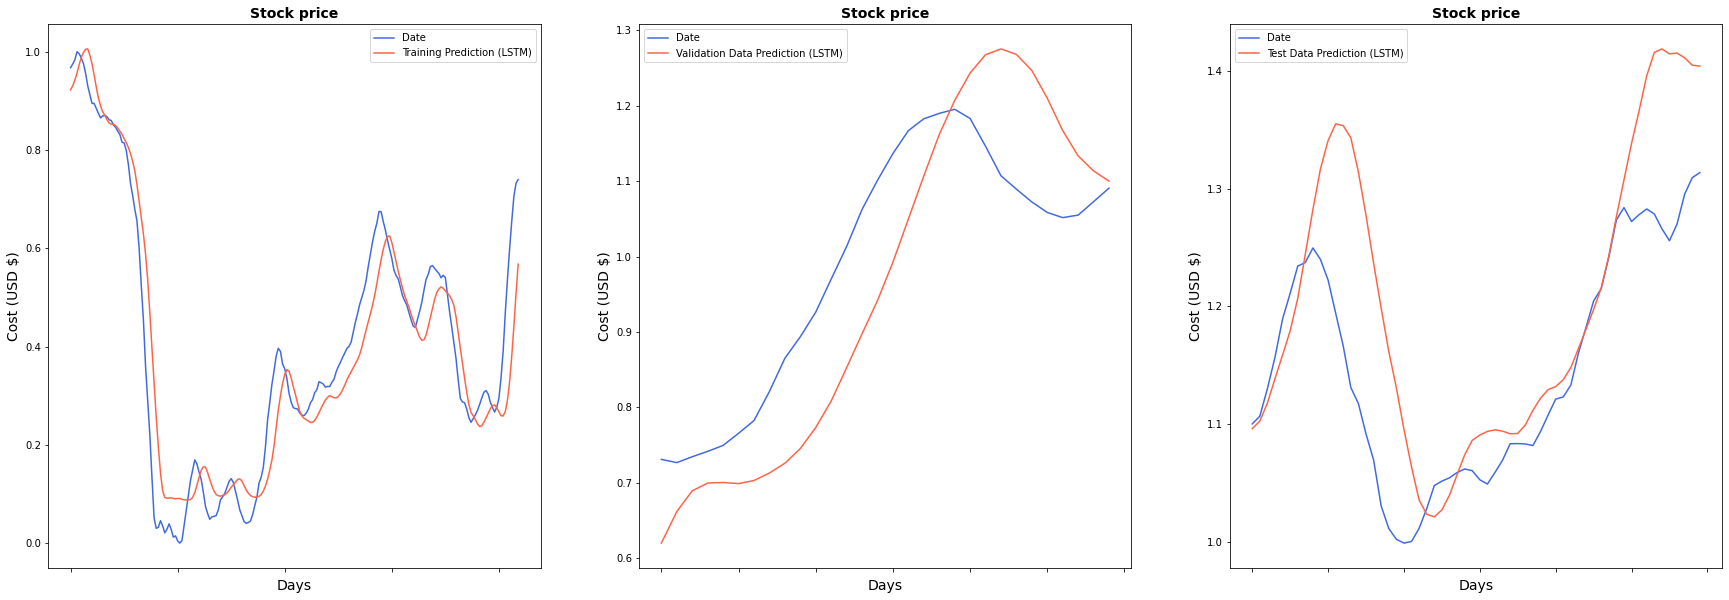

In [15]:
y_train_predict =model.predict(X_train)
y_val_predict =model.predict(X_val)
y_test_predict =model.predict(X_test)

plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict)

In [16]:
predictions=np.concatenate([y_train_predict, y_val_predict, y_test_predict])


In [17]:
def scaler_inverse(train_array, predictions):
    scaler = MinMaxScaler(feature_range = (0,1))
    c = train_array.reshape(-1,1)
    scaler.fit(c)
    prediction_inverse = scaler.inverse_transform(predictions)
    return prediction_inverse

In [18]:
pred_prices = scaler_inverse(train_array=train["y"].values,
                            predictions=predictions)

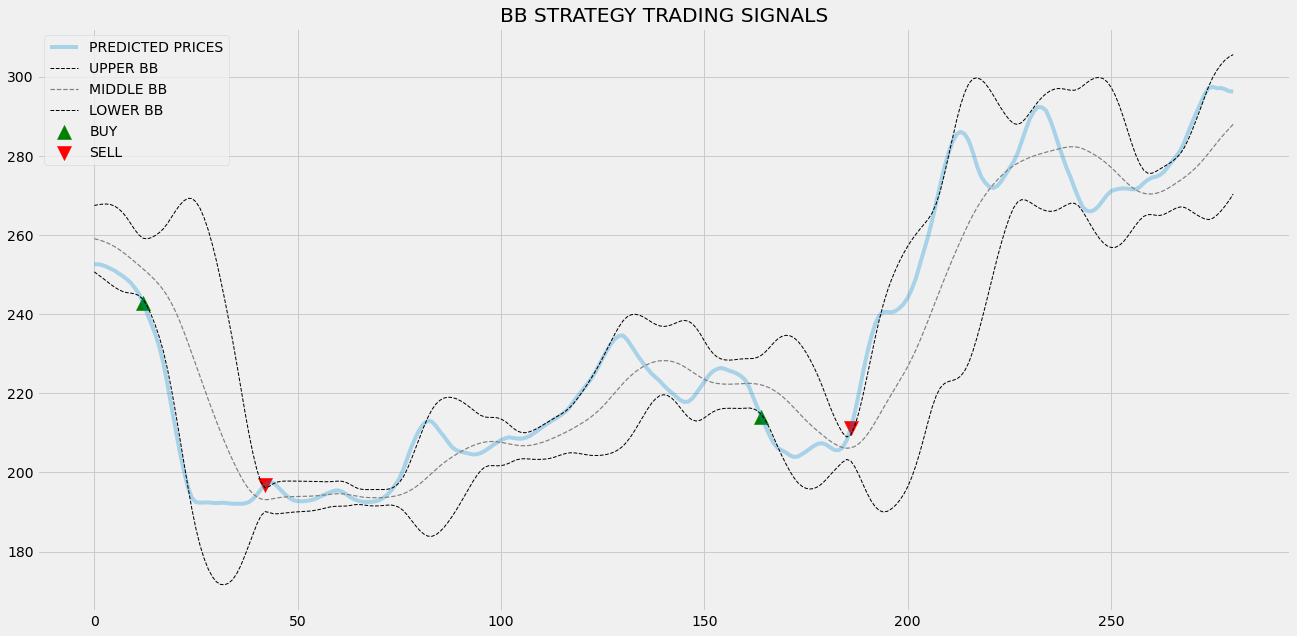

The actual returns had a value of 14.51% and the predicted returns had a value 17.28%


In [19]:
actuals=SBER_df_featured["y"].values
bolling_df =get_bollinger_df(actuals, pred_prices, 20)

### Using Turkey-KOC Holdingg AS(KCHOL) dataset

In [20]:
KOC_df=pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx", 1)[:-1]
KOC_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,19.41,19.42,19.63,19.27,13.14M,-0.0046
1,2021-03-30 00:00:00,19.5,19.12,19.81,19.03,21.05M,0.0209
2,2021-03-29 00:00:00,19.1,19.24,19.67,19.1,16.56M,-0.0078
3,2021-03-26 00:00:00,19.25,20.28,20.36,19.1,21.35M,-0.0385
4,2021-03-25 00:00:00,20.02,20.5,20.86,20.02,15.93M,-0.0148


In [21]:
KOC_df["Date"] = pd.to_datetime(KOC_df["Date"])
KOC_df.set_index("Date", inplace=True)
KOC_df =KOC_df[["Price"]]
KOC_df.columns=["price"]
KOC_df =KOC_df.sort_index()
KOC_df = KOC_df.rolling(7).mean().dropna()
KOC_df.head()

,price
Date,
2020-01-10,20.227143
2020-01-13,20.287143
2020-01-14,20.378571
2020-01-15,20.490000
2020-01-16,20.582857


In [22]:
KOC_df_featured =Lookback_data(KOC_df,5)
KOC_df_featured.head()

,0,1,2,3,4,y
Date,,,,,,
2020-01-17,20.227143,20.287143,20.378571,20.490000,20.582857,20.754286
2020-01-20,20.287143,20.378571,20.490000,20.582857,20.754286,20.908571
2020-01-21,20.378571,20.490000,20.582857,20.754286,20.908571,21.031429
2020-01-22,20.490000,20.582857,20.754286,20.908571,21.031429,21.071429
2020-01-23,20.582857,20.754286,20.908571,21.031429,21.071429,21.088571


### Splitting Dataset


In [23]:
train_ratio=0.7
validation_ratio  =0.1

train_ratio +validation_ratio <= 0.8
train_size = int(len(KOC_df_featured) *+train_ratio)
val_size =int(len(KOC_df_featured) *validation_ratio)
test_size = len(KOC_df_featured) -train_size-val_size

train, val,  test = KOC_df_featured.iloc[0:train_size,:], KOC_df_featured.iloc[train_size: train_size + val_size,:]  ,\
        KOC_df_featured.iloc[train_size+val_size:len(KOC_df_featured),:]

In [24]:

scaler =MinMaxScaler(feature_range=(0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train[train.columns]))
val_scaled =pd.DataFrame(scaler.transform(val[val.columns]))
test_scaled =pd.DataFrame(scaler.transform(test[test.columns]))


train_scaled.columns =["day1","day2", "day3", "day4", "day5", "y"]
val_scaled.columns=["day1","day2", "day3", "day4", "day5", "y"]
test_scaled.columns = ["day1","day2", "day3", "day4", "day5", "y"]



## separting dataset into train, validation & test
# Training
X_train =train_scaled.drop("y", axis=1).values
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train =train_scaled["y"].values

# Validation
X_val =val_scaled.drop("y", axis=1).values
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val =val_scaled["y"].values

# Test
X_test =test_scaled.drop("y", axis=1).values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test =test_scaled["y"].values

In [25]:
model = Sequential()
model.add(LSTM(200,return_sequences=True,activation="relu", input_shape=(5,1)))
model.add(LSTM(200, return_sequences=True, activation="relu"))
model.add(LSTM(200))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 200)            161600    
                                                                 
 lstm_4 (LSTM)               (None, 5, 200)            320800    
                                                                 
 lstm_5 (LSTM)               (None, 200)               320800    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train , epochs=100, batch_size= 32, 
         validation_data = (X_val, y_val),
         callbacks=callbacks)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.1560
Epoch 1: val_loss did not improve from 0.01144
7/7 [==============================] - 3s 121ms/step - loss: 0.1560 - val_loss: 0.1055 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.0470
Epoch 2: val_loss did not improve from 0.01144
7/7 [==============================] - 0s 42ms/step - loss: 0.0470 - val_loss: 0.0524 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0355
Epoch 3: val_loss did not improve from 0.01144
7/7 [==============================] - 0s 42ms/step - loss: 0.0355 - val_loss: 0.0807 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.0181
Epoch 4: val_loss improved from 0.01144 to 0.00225, saving model to model.h5
7/7 [==============================] - 1s 83ms/step - loss: 0.0181 - val_loss: 0.0023 - lr: 0.0010
Epoch 5/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0107
Epoch 5: val_lo

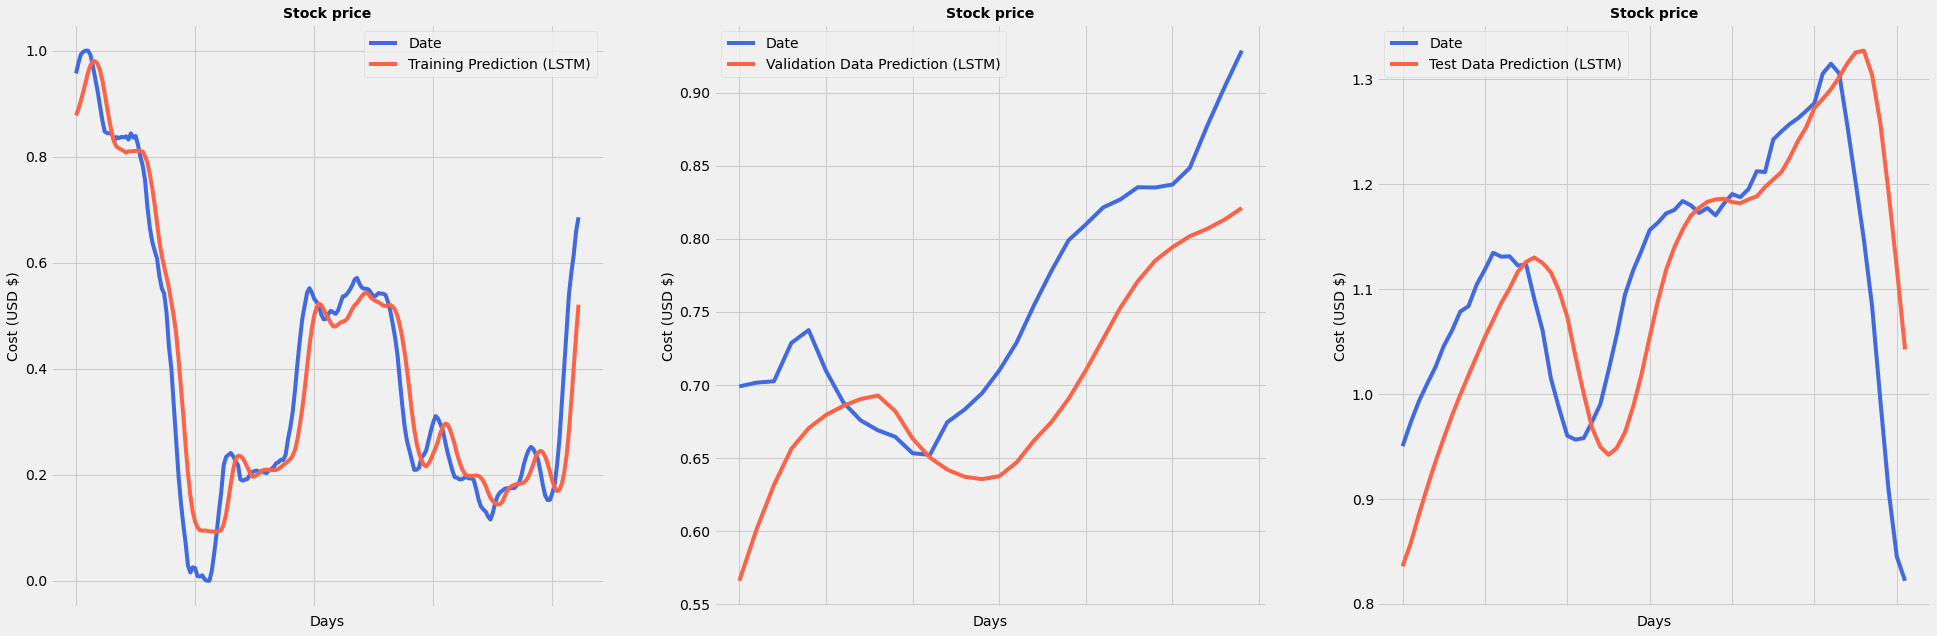

In [27]:
y_train_predict =model.predict(X_train)
y_val_predict =model.predict(X_val)
y_test_predict =model.predict(X_test)


plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict)

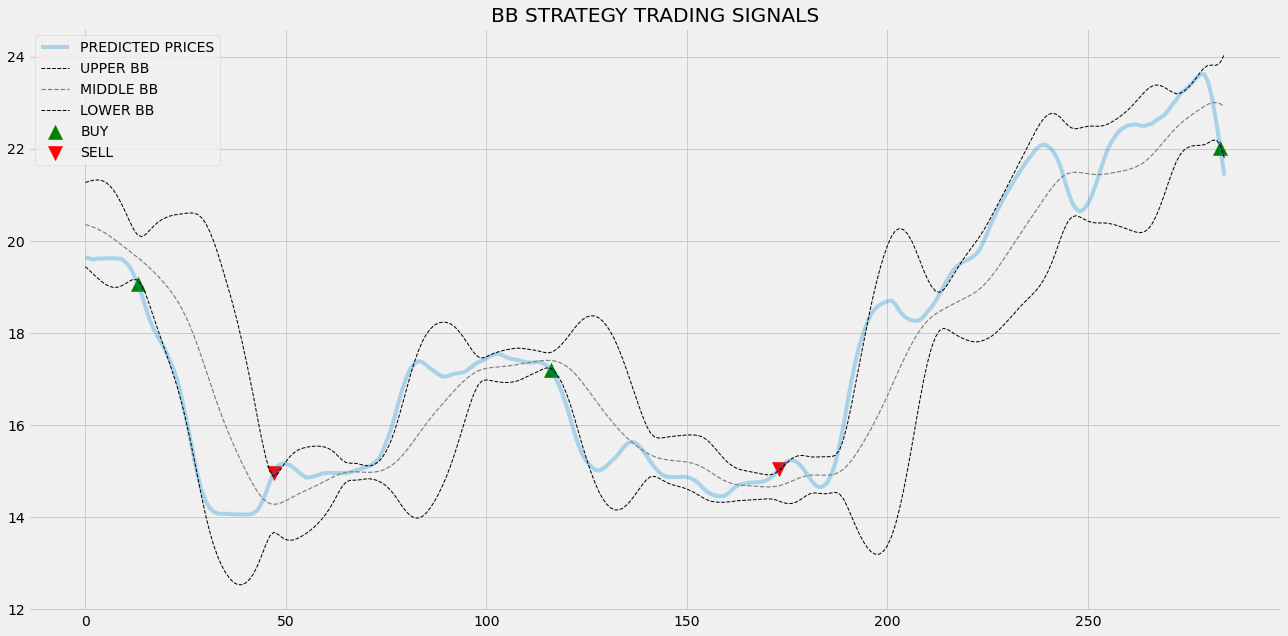

The actual returns had a value of -0.57% and the predicted returns had a value 9.15%


In [28]:
predictions=np.concatenate([y_train_predict, y_val_predict, y_test_predict])
pred_prices =scaler_inverse(train_array=train["y"].values,
                           predictions=predictions)
actuals = KOC_df_featured["y"].values
bolling_df =get_bollinger_df(actuals, pred_prices, 20)

## Using Egypt -Medinet NASR housing (MNHD) dataset

In [29]:
MNHD_df =pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx",2)[:-1]
MNHD_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,3.75,3.74,3.82,3.71,1.57M,0.0054
1,2021-03-30 00:00:00,3.73,3.71,3.76,3.67,3.43M,0.0081
2,2021-03-29 00:00:00,3.7,3.69,3.73,3.68,1.25M,-0.0027
3,2021-03-28 00:00:00,3.71,3.76,3.76,3.68,2.34M,0.0000
4,2021-03-25 00:00:00,3.71,3.62,3.78,3.59,2.50M,0.0137


In [30]:
MNHD_df["Date"] = pd.to_datetime(MNHD_df["Date"])
MNHD_df.set_index("Date", inplace=True)
MNHD_df =MNHD_df[["Price"]]
MNHD_df.columns=["price"]
MNHD_df =MNHD_df.sort_index()
MNHD_df = MNHD_df.rolling(7).mean().dropna()
MNHD_df.head()

,price
Date,
2020-01-13,4.575714
2020-01-14,4.572857
2020-01-15,4.640000
2020-01-16,4.727143
2020-01-19,4.782857


In [31]:
MNHD_df_featured =Lookback_data(MNHD_df,5)
MNHD_df_featured.head()

,0,1,2,3,4,y
Date,,,,,,
2020-01-20,4.575714,4.572857,4.640000,4.727143,4.782857,4.797143
2020-01-21,4.572857,4.640000,4.727143,4.782857,4.797143,4.775714
2020-01-22,4.640000,4.727143,4.782857,4.797143,4.775714,4.768571
2020-01-23,4.727143,4.782857,4.797143,4.775714,4.768571,4.752857
2020-01-26,4.782857,4.797143,4.775714,4.768571,4.752857,4.725714


#### Splitting Dataset

In [32]:
train_ratio = 0.7
validation_ratio = 0.1

train_ratio +validation_ratio <= 0.8  # Train + validation ratio shold be less than or equal to 0.8
train_size =int(len(MNHD_df_featured) *train_ratio)
val_size =int(len(MNHD_df_featured) *validation_ratio)
test_size = len(MNHD_df_featured) -train_size-val_size


train, val, test = MNHD_df_featured.iloc[0:train_size,:], MNHD_df_featured.iloc[train_size: train_size + val_size,:]  ,\
                MNHD_df_featured.iloc[train_size+val_size:len(MNHD_df_featured),:]


In [33]:

scaler =MinMaxScaler(feature_range=(0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train[train.columns]))
val_scaled =pd.DataFrame(scaler.transform(val[val.columns]))
test_scaled =pd.DataFrame(scaler.transform(test[test.columns]))


train_scaled.columns =["day1","day2", "day3", "day4", "day5", "y"]
val_scaled.columns=["day1","day2", "day3", "day4", "day5", "y"]
test_scaled.columns = ["day1","day2", "day3", "day4", "day5", "y"]



## separting dataset into train, validation & test
# Training
X_train =train_scaled.drop("y", axis=1).values
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train =train_scaled["y"].values

# Validation
X_val =val_scaled.drop("y", axis=1).values
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val =val_scaled["y"].values

# Test
X_test =test_scaled.drop("y", axis=1).values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test =test_scaled["y"].values

In [34]:
model = Sequential()
model.add(LSTM(300,return_sequences=True,activation="relu", input_shape=(5,1)))
model.add(LSTM(300, return_sequences=True, activation="relu"))
model.add(LSTM(300))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 300)            362400    
                                                                 
 lstm_7 (LSTM)               (None, 5, 300)            721200    
                                                                 
 lstm_8 (LSTM)               (None, 300)               721200    
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train , epochs=100, batch_size= 32, 
         validation_data = (X_val, y_val),
         callbacks=callbacks)

Epoch 1/100
6/7 [========================>.....] - ETA: 0s - loss: 0.1417
Epoch 1: val_loss did not improve from 0.00225
7/7 [==============================] - 3s 132ms/step - loss: 0.1350 - val_loss: 0.0406 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.0499
Epoch 2: val_loss did not improve from 0.00225
7/7 [==============================] - 0s 48ms/step - loss: 0.0499 - val_loss: 0.0358 - lr: 0.0010
Epoch 3/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0213
Epoch 3: val_loss did not improve from 0.00225
7/7 [==============================] - 0s 49ms/step - loss: 0.0206 - val_loss: 0.0123 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.0100
Epoch 4: val_loss did not improve from 0.00225
7/7 [==============================] - 0s 46ms/step - loss: 0.0100 - val_loss: 0.0035 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - ETA: 0s - loss: 0.0070
Epoch 5: val_loss improved from 0.00225 to 0.

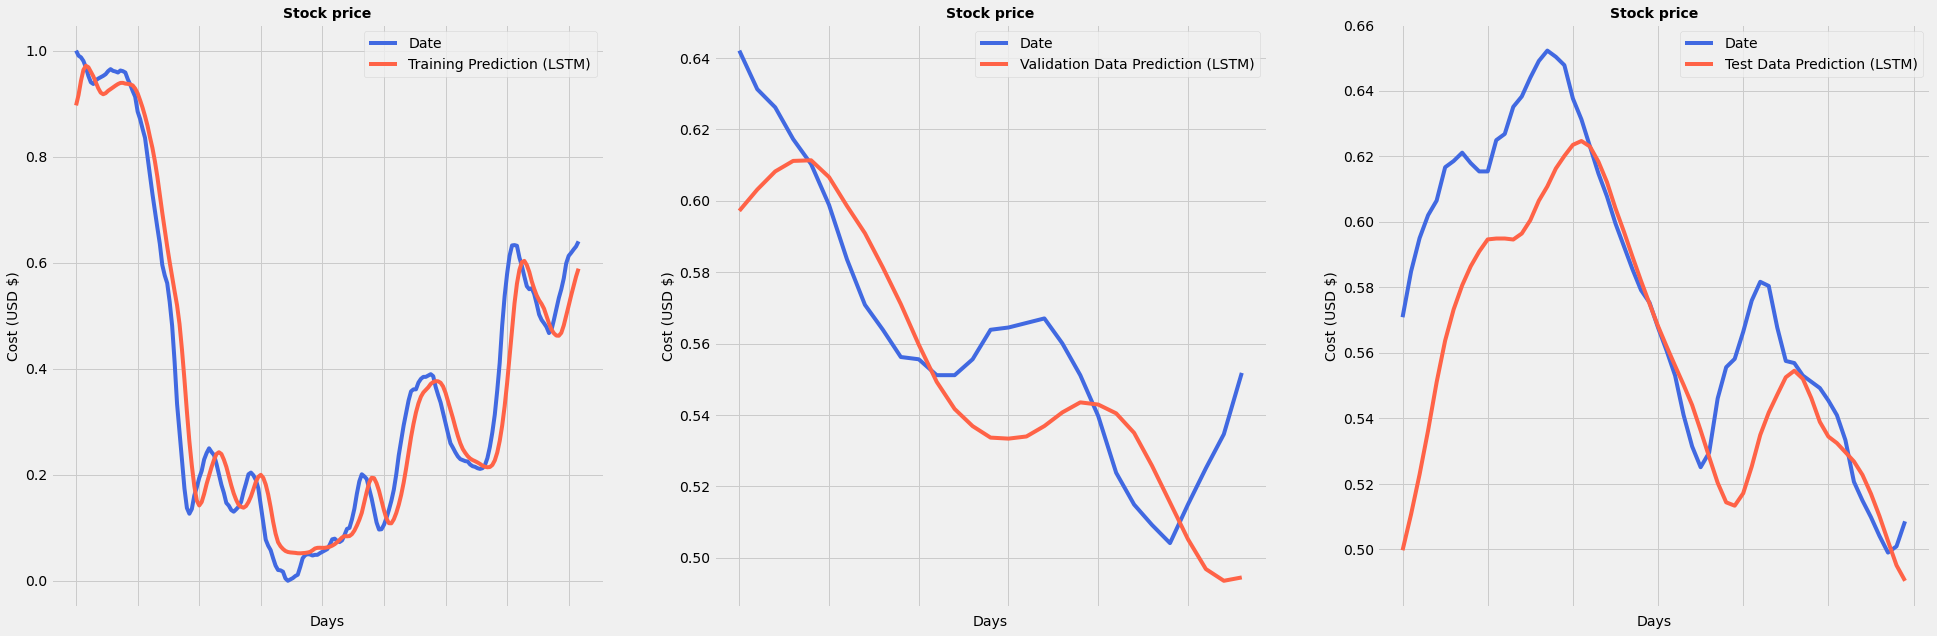

In [36]:
y_train_predict =model.predict(X_train)
y_val_predict =model.predict(X_val)
y_test_predict =model.predict(X_test)


plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict)

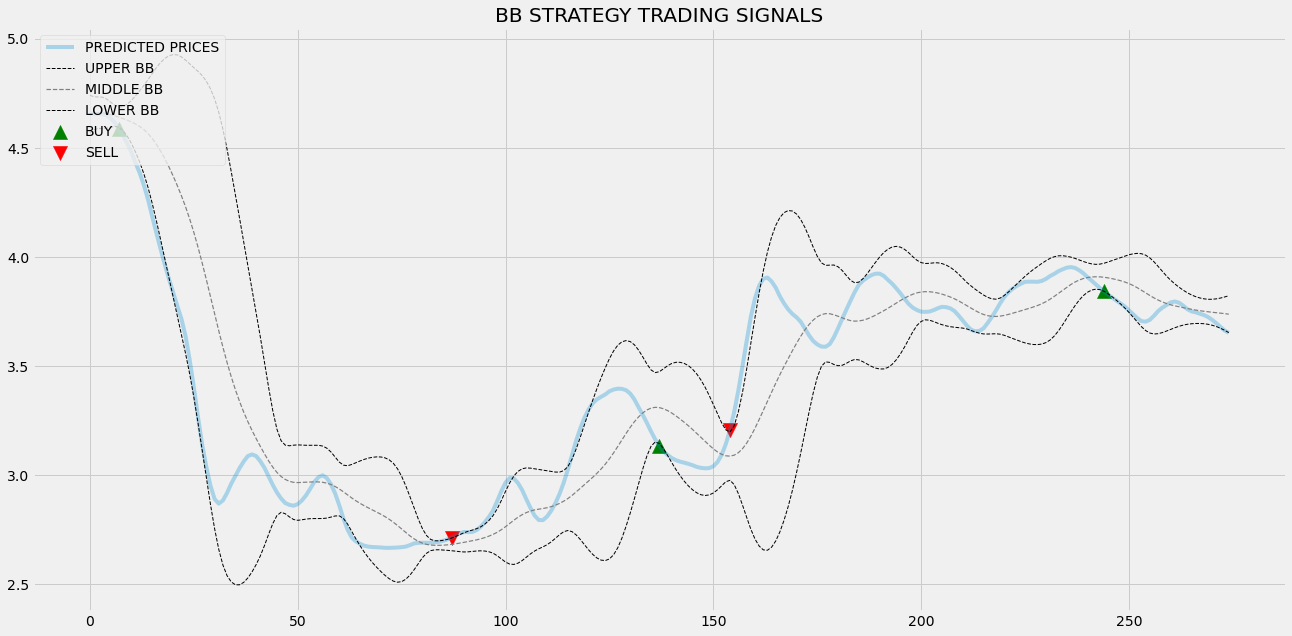

The actual returns had a value of -21.5% and the predicted returns had a value -21.58%


In [37]:
predictions=np.concatenate([y_train_predict, y_val_predict, y_test_predict])
pred_prices =scaler_inverse(train_array=train["y"].values,
                           predictions=predictions)
actuals = MNHD_df_featured["y"].values
bolling_df =get_bollinger_df(actuals, pred_prices, 20)

### Using Brazil -Minerva SA/Brazil(BEEF3) dataset

In [38]:
BEEF_df =pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx", 3)[:-1]
BEEF_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,10.2,10.35,10.4,10.12,7.77M,-0.0154
1,2021-03-30 00:00:00,10.36,10.41,10.62,10.3,9.93M,-0.0105
2,2021-03-29 00:00:00,10.47,9.85,10.5,9.81,22.04M,0.0651
3,2021-03-26 00:00:00,9.83,9.8,9.94,9.7,5.11M,0.0031
4,2021-03-25 00:00:00,9.8,10.01,10.01,9.66,8.88M,-0.0151


In [39]:
BEEF_df["Date"] = pd.to_datetime(BEEF_df["Date"])
BEEF_df.set_index("Date", inplace=True)
BEEF_df =BEEF_df[["Price"]]
BEEF_df.columns=["price"]
BEEF_df =BEEF_df.sort_index()
BEEF_df = BEEF_df.rolling(7).mean().dropna()
BEEF_df.head()

,price
Date,
2020-01-10,13.178571
2020-01-13,13.462857
2020-01-14,13.684286
2020-01-15,13.900000
2020-01-16,14.115714


In [40]:
BEEF_df_featured =Lookback_data(BEEF_df,5)
BEEF_df_featured.head()

,0,1,2,3,4,y
Date,,,,,,
2020-01-17,13.178571,13.462857,13.684286,13.900000,14.115714,14.290000
2020-01-20,13.462857,13.684286,13.900000,14.115714,14.290000,14.497143
2020-01-21,13.684286,13.900000,14.115714,14.290000,14.497143,14.762857
2020-01-22,13.900000,14.115714,14.290000,14.497143,14.762857,14.690000
2020-01-23,14.115714,14.290000,14.497143,14.762857,14.690000,14.664286


In [41]:
train_ratio=0.7
validation_ratio  =0.1

train_ratio +validation_ratio <= 0.8
train_size = int(len(BEEF_df_featured) *+train_ratio)
val_size =int(len(BEEF_df_featured) *validation_ratio)
test_size = len(BEEF_df_featured) -train_size-val_size

train, val,  test = BEEF_df_featured.iloc[0:train_size,:], BEEF_df_featured.iloc[train_size: train_size + val_size,:]  ,\
        BEEF_df_featured.iloc[train_size+val_size:len(BEEF_df_featured),:]

In [42]:

scaler =MinMaxScaler(feature_range=(0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train[train.columns]))
val_scaled =pd.DataFrame(scaler.transform(val[val.columns]))
test_scaled =pd.DataFrame(scaler.transform(test[test.columns]))


train_scaled.columns =["day1","day2", "day3", "day4", "day5", "y"]
val_scaled.columns=["day1","day2", "day3", "day4", "day5", "y"]
test_scaled.columns = ["day1","day2", "day3", "day4", "day5", "y"]



## separting dataset into train, validation & test
# Training
X_train =train_scaled.drop("y", axis=1).values
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train =train_scaled["y"].values

# Validation
X_val =val_scaled.drop("y", axis=1).values
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val =val_scaled["y"].values

# Test
X_test =test_scaled.drop("y", axis=1).values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test =test_scaled["y"].values

In [43]:
model = Sequential()
model.add(LSTM(300,return_sequences=True,activation="relu", input_shape=(5,1)))
model.add(LSTM(300, return_sequences=True, activation="relu"))
model.add(LSTM(300))
model.add(Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 5, 300)            362400    
                                                                 
 lstm_10 (LSTM)              (None, 5, 300)            721200    
                                                                 
 lstm_11 (LSTM)              (None, 300)               721200    
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train , epochs=100, batch_size= 32, 
         validation_data = (X_val, y_val),
         callbacks=callbacks)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.2743
Epoch 1: val_loss did not improve from 0.00047
7/7 [==============================] - 3s 129ms/step - loss: 0.2743 - val_loss: 0.0615 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.0647
Epoch 2: val_loss did not improve from 0.00047
7/7 [==============================] - 0s 48ms/step - loss: 0.0647 - val_loss: 7.5057e-04 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0615
Epoch 3: val_loss did not improve from 0.00047
7/7 [==============================] - 0s 47ms/step - loss: 0.0615 - val_loss: 0.0063 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.0260
Epoch 4: val_loss did not improve from 0.00047
7/7 [==============================] - 0s 49ms/step - loss: 0.0260 - val_loss: 0.0445 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - ETA: 0s - loss: 0.0196
Epoch 5: ReduceLROnPlateau reducing learn

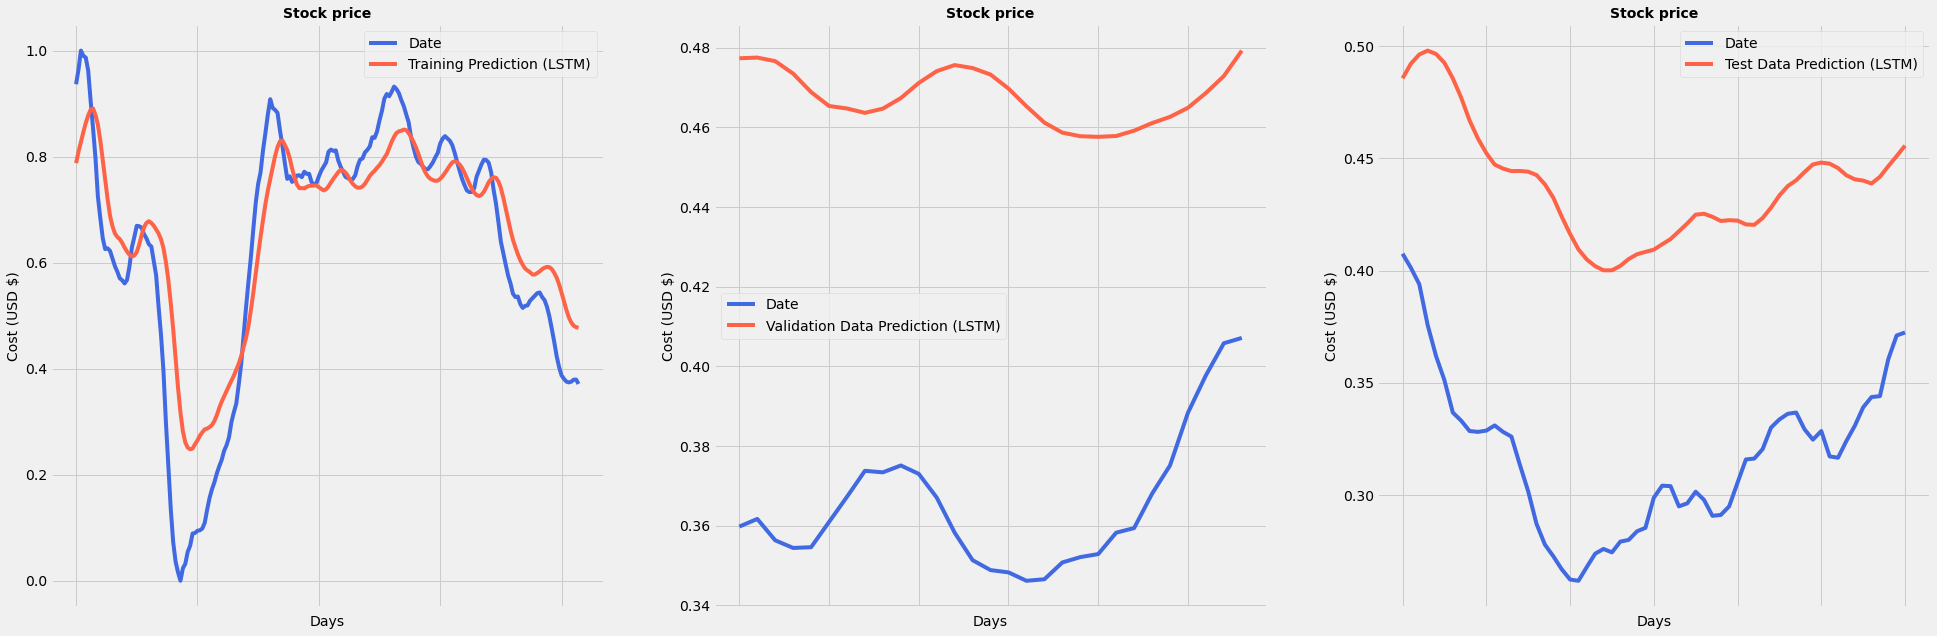

In [45]:
y_train_predict =model.predict(X_train)
y_val_predict =model.predict(X_val)
y_test_predict =model.predict(X_test)


plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict)

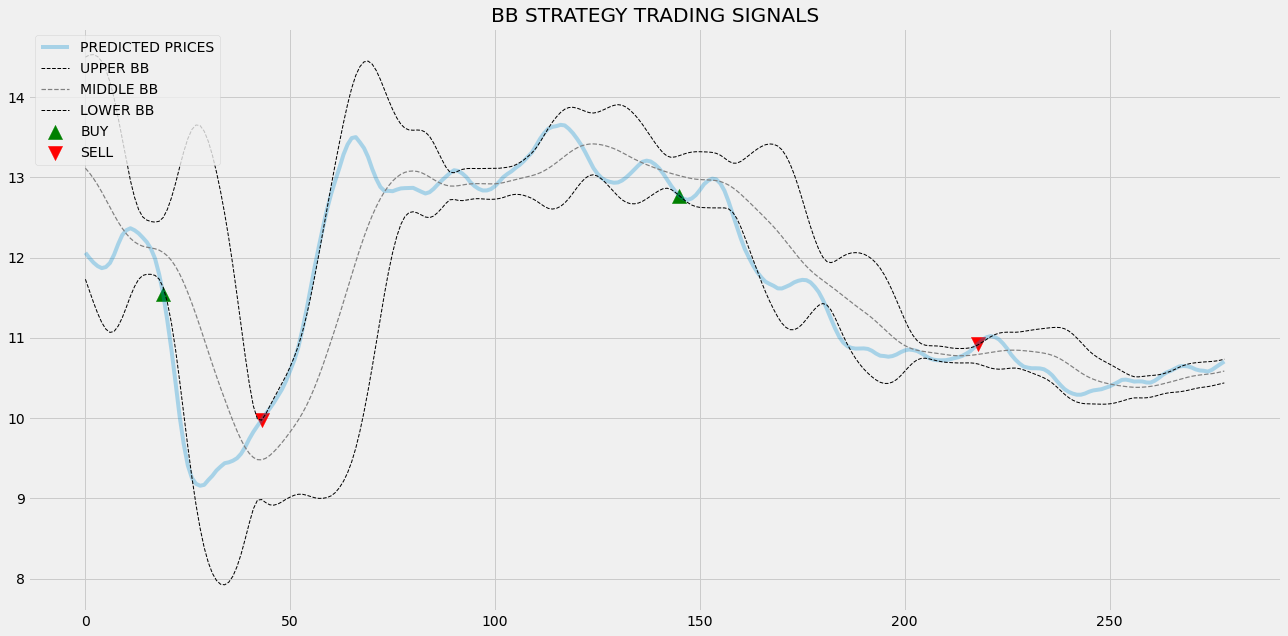

The actual returns had a value of -12.22% and the predicted returns had a value -10.74%


In [46]:
predictions=np.concatenate([y_train_predict, y_val_predict, y_test_predict])
pred_prices =scaler_inverse(train_array=train["y"].values,
                           predictions=predictions)
actuals = BEEF_df_featured["y"].values
bolling_df =get_bollinger_df(actuals, pred_prices, 20)

### Using Argentina- Pampa Energia SA(PAMP) dataset

In [47]:
PAMP_df =pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx",4)[:-1]
PAMP_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,85.15,86.5,88.1,85.15,564.30K,-0.0110
1,2021-03-30 00:00:00,86.1,85.15,86.75,84.6,141.40K,0.0129
2,2021-03-29 00:00:00,85.0,80.0,86.0,79.0,371.22K,0.0385
3,2021-03-26 00:00:00,81.85,84.0,84.6,80.7,462.55K,-0.0209
4,2021-03-25 00:00:00,83.6,85.2,87.3,82.1,389.78K,-0.0313


In [48]:
PAMP_df["Date"] =pd.to_datetime(PAMP_df["Date"])
PAMP_df.set_index("Date", inplace=True)
PAMP_df=PAMP_df[["Price"]]
PAMP_df.columns=["price"]
PAMP_df= PAMP_df.sort_index()
PAMP_df =PAMP_df.rolling(7).mean().dropna()
PAMP_df.head()

,price
Date,
2020-01-10,47.992857
2020-01-13,47.900000
2020-01-14,47.478571
2020-01-15,47.221429
2020-01-16,47.092857


In [49]:
PAMP_df_featured =Lookback_data(PAMP_df,5)
PAMP_df_featured.head()

,0,1,2,3,4,y
Date,,,,,,
2020-01-17,47.992857,47.900000,47.478571,47.221429,47.092857,47.357143
2020-01-20,47.900000,47.478571,47.221429,47.092857,47.357143,47.521429
2020-01-21,47.478571,47.221429,47.092857,47.357143,47.521429,47.350000
2020-01-22,47.221429,47.092857,47.357143,47.521429,47.350000,47.471429
2020-01-23,47.092857,47.357143,47.521429,47.350000,47.471429,47.550000


#### Splitting Dataset

In [50]:
train_ratio=0.7
validation_ratio=0.1

train_ratio +validation_ratio <=0.8
train_size =int(len(PAMP_df_featured) * + train_ratio)
val_size =int(len(PAMP_df_featured) * validation_ratio)
test_size =len(PAMP_df_featured) -train_size -val_size

train, val,  test = PAMP_df_featured.iloc[0:train_size,:], PAMP_df_featured.iloc[train_size: train_size + val_size,:]  ,\
        PAMP_df_featured.iloc[train_size+val_size:len(PAMP_df_featured),:]

In [51]:

scaler =MinMaxScaler(feature_range=(0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train[train.columns]))
val_scaled =pd.DataFrame(scaler.transform(val[val.columns]))
test_scaled =pd.DataFrame(scaler.transform(test[test.columns]))


train_scaled.columns =["day1","day2", "day3", "day4", "day5", "y"]
val_scaled.columns=["day1","day2", "day3", "day4", "day5", "y"]
test_scaled.columns = ["day1","day2", "day3", "day4", "day5", "y"]



## separting dataset into train, validation & test
# Training
X_train =train_scaled.drop("y", axis=1).values
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train =train_scaled["y"].values

# Validation
X_val =val_scaled.drop("y", axis=1).values
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val =val_scaled["y"].values

# Test
X_test =test_scaled.drop("y", axis=1).values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test =test_scaled["y"].values

In [52]:
model = Sequential()
model.add(LSTM(200,return_sequences=True,activation="relu", input_shape=(5,1)))
model.add(LSTM(200, return_sequences=True, activation="relu"))
model.add(LSTM(200))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 200)            161600    
                                                                 
 lstm_13 (LSTM)              (None, 5, 200)            320800    
                                                                 
 lstm_14 (LSTM)              (None, 200)               320800    
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train , epochs=100, batch_size= 32, 
         validation_data = (X_val, y_val),
         callbacks=callbacks)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.1474
Epoch 1: val_loss did not improve from 0.00047
7/7 [==============================] - 3s 123ms/step - loss: 0.1474 - val_loss: 0.2908 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.0352
Epoch 2: val_loss did not improve from 0.00047
7/7 [==============================] - 0s 43ms/step - loss: 0.0352 - val_loss: 0.0960 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0271
Epoch 3: val_loss did not improve from 0.00047
7/7 [==============================] - 0s 42ms/step - loss: 0.0271 - val_loss: 0.1032 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.0124
Epoch 4: val_loss did not improve from 0.00047
7/7 [==============================] - 0s 43ms/step - loss: 0.0124 - val_loss: 0.0054 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - ETA: 0s - loss: 0.0056
Epoch 5: val_loss did not improve from 0.0004

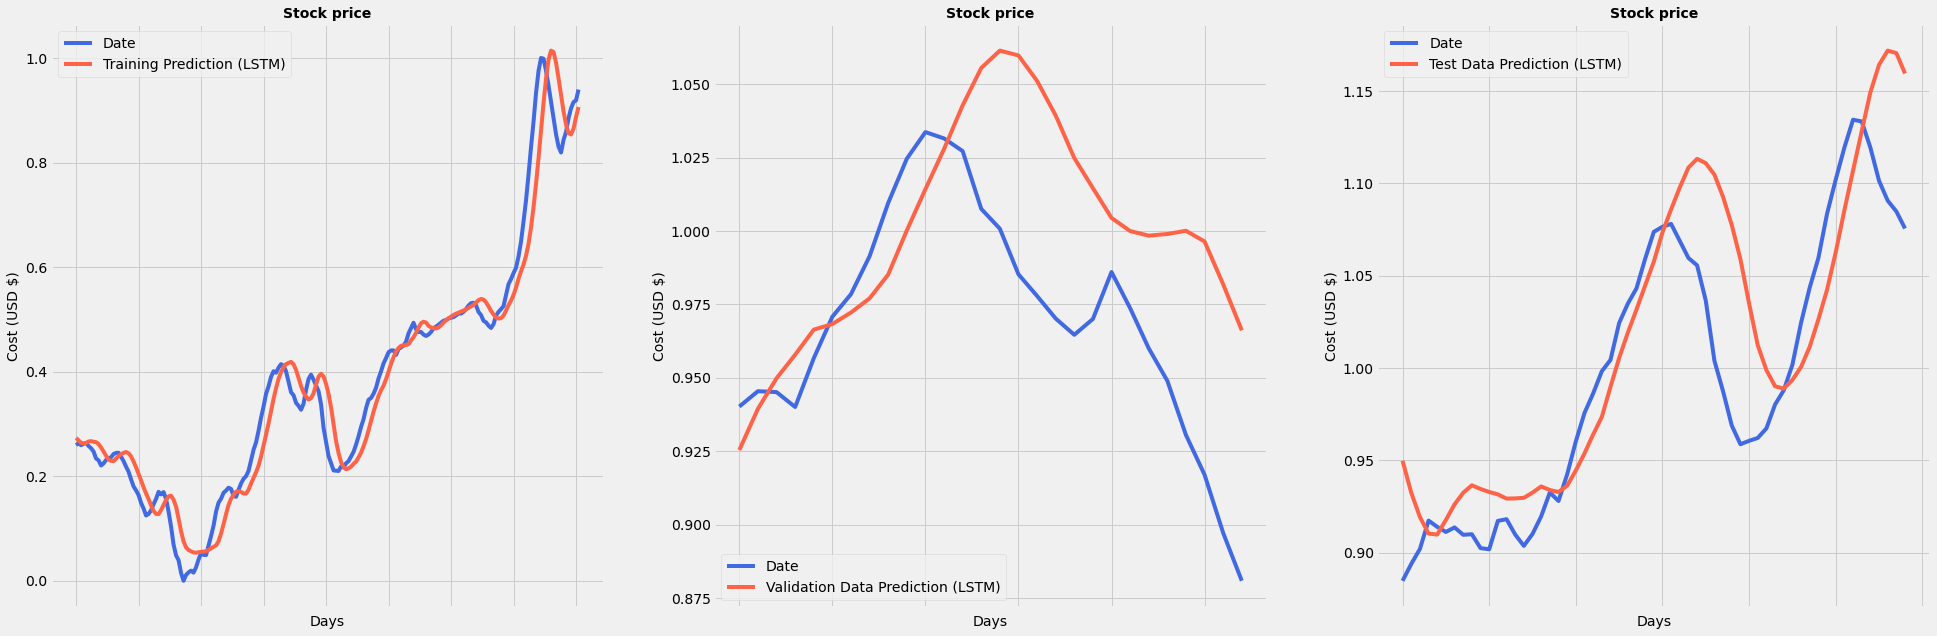

In [54]:
y_train_predict =model.predict(X_train)
y_val_predict =model.predict(X_val)
y_test_predict =model.predict(X_test)


plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict)

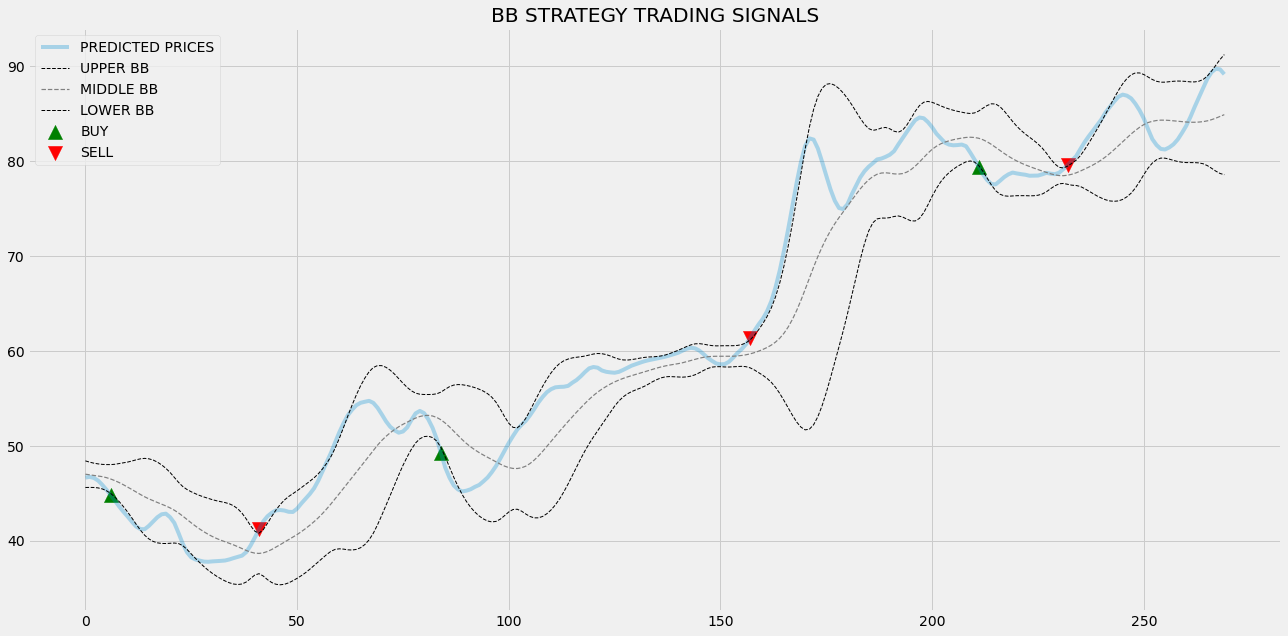

The actual returns had a value of 87.65% and the predicted returns had a value 90.76%


In [55]:
predictions=np.concatenate([y_train_predict, y_val_predict, y_test_predict])
pred_prices =scaler_inverse(train_array=train["y"].values,
                           predictions=predictions)
actuals = PAMP_df_featured["y"].values
bolling_df =get_bollinger_df(actuals, pred_prices, 20)

### Using Colombia -Cementos Argos SA (CCB) dataset

In [56]:
CCB_df =pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx",5) [:-1]
CCB_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,5150.0,5100.0,5170.0,5100.0,212.44K,0.0098
1,2021-03-30 00:00:00,5100.0,5010.0,5100.0,5010.0,583.70K,0.0109
2,2021-03-29 00:00:00,5045.0,5020.0,5045.0,5015.0,117.54K,0.0050
3,2021-03-26 00:00:00,5020.0,5085.0,5085.0,4980.0,203.46K,-0.0020
4,2021-03-25 00:00:00,5030.0,5035.0,5045.0,4950.0,317.06K,0.0010


In [57]:
CCB_df["Date"] = pd.to_datetime(CCB_df["Date"])
CCB_df.set_index("Date", inplace=True)
CCB_df =CCB_df[["Price"]]
CCB_df.columns=["price"]
CCB_df =CCB_df.sort_index()
CCB_df = CCB_df.rolling(7).mean().dropna()
CCB_df.head()

,price
Date,
2020-01-13,6884.285714
2020-01-14,6815.714286
2020-01-15,6754.285714
2020-01-16,6701.428571
2020-01-17,6670.000000


In [58]:
CCB_df_featured =Lookback_data(CCB_df,5)
CCB_df_featured.head()

,0,1,2,3,4,y
Date,,,,,,
2020-01-20,6884.285714,6815.714286,6754.285714,6701.428571,6670.000000,6660.000000
2020-01-21,6815.714286,6754.285714,6701.428571,6670.000000,6660.000000,6644.285714
2020-01-22,6754.285714,6701.428571,6670.000000,6660.000000,6644.285714,6640.000000
2020-01-23,6701.428571,6670.000000,6660.000000,6644.285714,6640.000000,6634.285714
2020-01-24,6670.000000,6660.000000,6644.285714,6640.000000,6634.285714,6624.285714


#### Splitting Dataset

In [59]:
train_ratio = 0.7
validation_ratio = 0.1

train_ratio +validation_ratio <= 0.8  # Train + validation ratio shold be less than or equal to 0.8
train_size =int(len(CCB_df_featured) *train_ratio)
val_size =int(len(CCB_df_featured) *validation_ratio)
test_size = len(CCB_df_featured) -train_size-val_size


train, val, test = CCB_df_featured.iloc[0:train_size,:], CCB_df_featured.iloc[train_size: train_size + val_size,:]  ,\
                CCB_df_featured.iloc[train_size+val_size:len(CCB_df_featured),:]


In [60]:

scaler =MinMaxScaler(feature_range=(0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train[train.columns]))
val_scaled =pd.DataFrame(scaler.transform(val[val.columns]))
test_scaled =pd.DataFrame(scaler.transform(test[test.columns]))


train_scaled.columns =["day1","day2", "day3", "day4", "day5", "y"]
val_scaled.columns=["day1","day2", "day3", "day4", "day5", "y"]
test_scaled.columns = ["day1","day2", "day3", "day4", "day5", "y"]



## separting dataset into train, validation & test
# Training
X_train =train_scaled.drop("y", axis=1).values
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train =train_scaled["y"].values

# Validation
X_val =val_scaled.drop("y", axis=1).values
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val =val_scaled["y"].values

# Test
X_test =test_scaled.drop("y", axis=1).values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test =test_scaled["y"].values

In [61]:
model = Sequential()
model.add(LSTM(200,return_sequences=True,activation="relu", input_shape=(5,1)))
model.add(LSTM(200, return_sequences=True, activation="relu"))
model.add(LSTM(200))
model.add(Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 5, 200)            161600    
                                                                 
 lstm_16 (LSTM)              (None, 5, 200)            320800    
                                                                 
 lstm_17 (LSTM)              (None, 200)               320800    
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train , epochs=100, batch_size= 32, 
         validation_data = (X_val, y_val),
         callbacks=callbacks)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.1672
Epoch 1: val_loss did not improve from 0.00047
7/7 [==============================] - 3s 120ms/step - loss: 0.1672 - val_loss: 0.0841 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.0466
Epoch 2: val_loss did not improve from 0.00047
7/7 [==============================] - 0s 44ms/step - loss: 0.0466 - val_loss: 0.0157 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0317
Epoch 3: val_loss did not improve from 0.00047
7/7 [==============================] - 0s 46ms/step - loss: 0.0317 - val_loss: 0.0639 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.0195
Epoch 4: val_loss did not improve from 0.00047
7/7 [==============================] - 0s 47ms/step - loss: 0.0195 - val_loss: 0.0012 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - ETA: 0s - loss: 0.0099
Epoch 5: val_loss did not improve from 0.0004

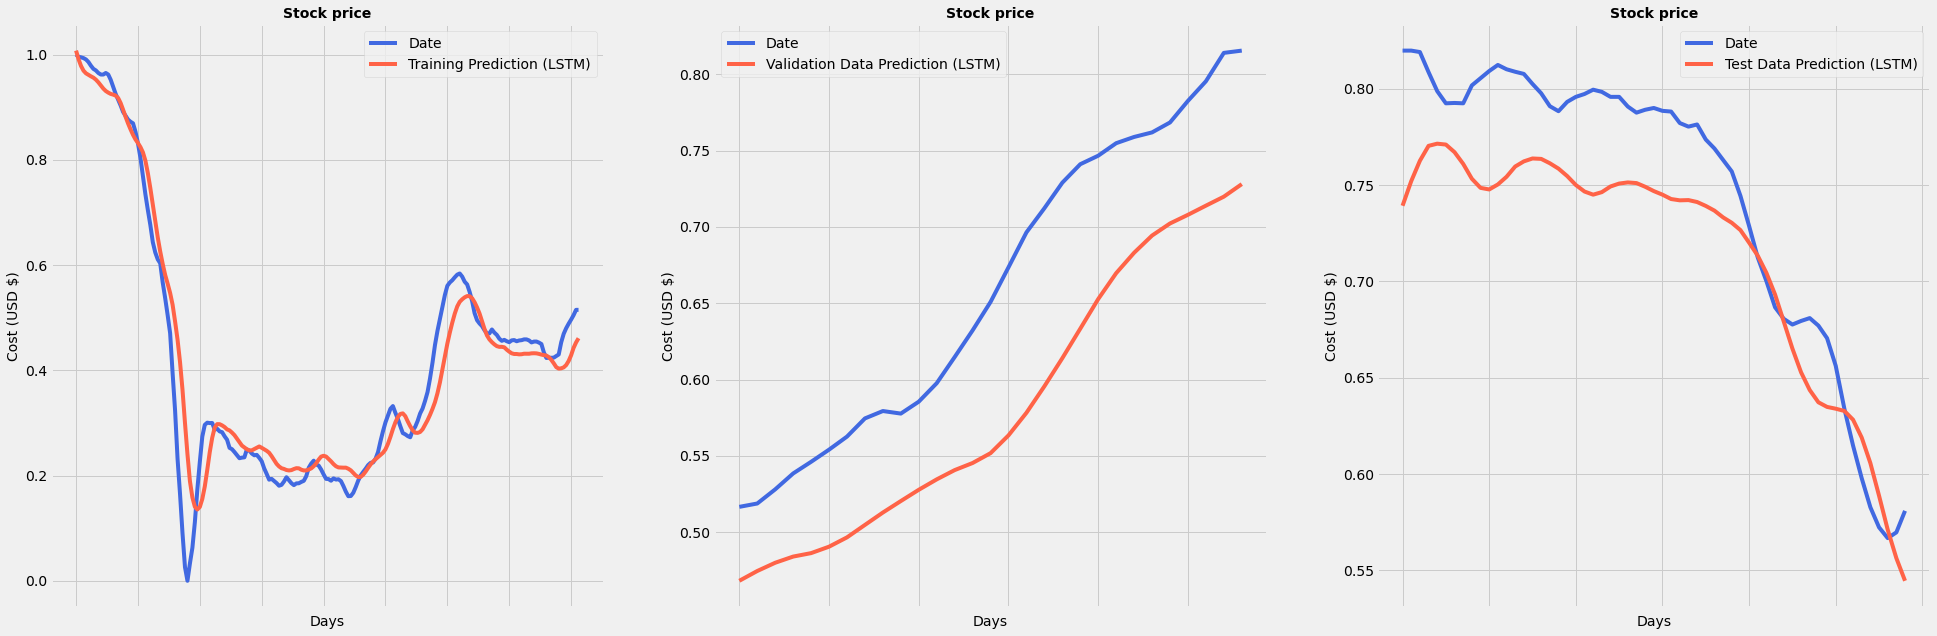

In [63]:
y_train_predict =model.predict(X_train)
y_val_predict =model.predict(X_val)
y_test_predict =model.predict(X_test)


plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict)

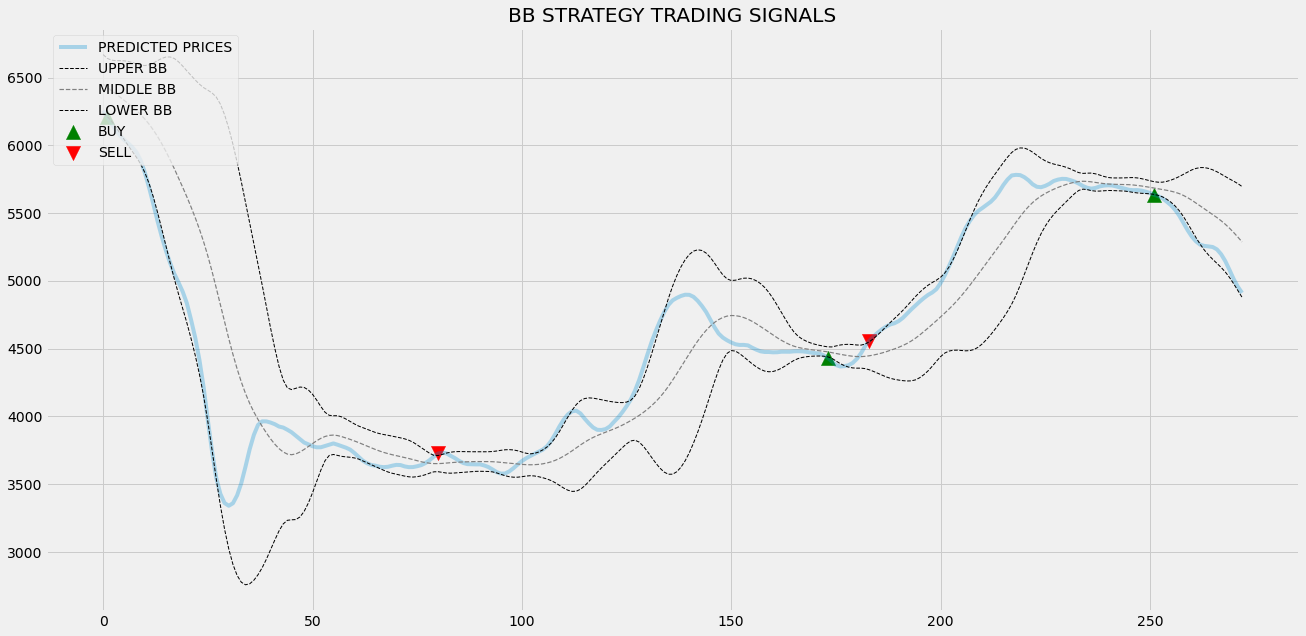

The actual returns had a value of -18.72% and the predicted returns had a value -20.86%


In [64]:
predictions=np.concatenate([y_train_predict, y_val_predict, y_test_predict])
pred_prices =scaler_inverse(train_array=train["y"].values,
                           predictions=predictions)
actuals = CCB_df_featured["y"].values
bolling_df =get_bollinger_df(actuals, pred_prices, 20)

#### Using South Africa -Impala Platinum Holding LTD(IMPJ) dataset 

In [65]:
MPJ_df = pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx", 6)[:-1]
MPJ_df.head()


,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,27373.0,26980.0,27526.0,26657.0,2.49M,0.0177
1,2021-03-30 00:00:00,26898.0,26766.0,27443.0,26360.0,3.02M,-0.0030
2,2021-03-29 00:00:00,26980.0,27800.0,28174.0,26614.0,4.44M,-0.0201
3,2021-03-26 00:00:00,27533.0,27083.0,28006.0,26728.0,3.36M,0.0365
4,2021-03-25 00:00:00,26564.0,25954.0,27128.0,25954.0,2.83M,0.0255


In [66]:
MPJ_df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
309,2020-01-08 00:00:00,15290.0,14775.0,15465.0,14468.0,6.24M,0.0545
310,2020-01-07 00:00:00,14500.0,14688.0,14688.0,13940.0,3.94M,-0.0082
311,2020-01-06 00:00:00,14620.0,14985.0,15045.0,14574.0,2.61M,-0.0150
312,2020-01-03 00:00:00,14843.0,14700.0,14884.0,14360.0,3.19M,0.0358
313,2020-01-02 00:00:00,14330.0,14525.0,14764.0,14325.0,2.01M,-0.0015


In [67]:
MPJ_df["Date"] = pd.to_datetime(MPJ_df["Date"])
MPJ_df.set_index("Date", inplace=True)
MPJ_df =MPJ_df[["Price"]]
MPJ_df.columns=["price"]
MPJ_df =MPJ_df.sort_index()
MPJ_df = MPJ_df.rolling(7).mean().dropna()
MPJ_df.head()

,price
Date,
2020-01-10,14789.714286
2020-01-13,14850.000000
2020-01-14,14797.714286
2020-01-15,14786.571429
2020-01-16,14857.142857


In [68]:
MPJ_df_featured =Lookback_data(MPJ_df,5)
MPJ_df_featured.head()

,0,1,2,3,4,y
Date,,,,,,
2020-01-17,14789.714286,14850.000000,14797.714286,14786.571429,14857.142857,14881.571429
2020-01-20,14850.000000,14797.714286,14786.571429,14857.142857,14881.571429,14999.571429
2020-01-21,14797.714286,14786.571429,14857.142857,14881.571429,14999.571429,14935.142857
2020-01-22,14786.571429,14857.142857,14881.571429,14999.571429,14935.142857,14905.285714
2020-01-23,14857.142857,14881.571429,14999.571429,14935.142857,14905.285714,14836.000000


In [69]:
train_ratio=0.7
validation_ratio  =0.1

train_ratio +validation_ratio <= 0.8
train_size = int(len(MPJ_df_featured) *+train_ratio)
val_size =int(len(MPJ_df_featured) *validation_ratio)
test_size = len(MPJ_df_featured) -train_size-val_size

train, val,  test = MPJ_df_featured.iloc[0:train_size,:], MPJ_df_featured.iloc[train_size: train_size + val_size,:]  ,\
        MPJ_df_featured.iloc[train_size+val_size:len(MPJ_df_featured),:]

In [70]:

scaler =MinMaxScaler(feature_range=(0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train[train.columns]))
val_scaled =pd.DataFrame(scaler.transform(val[val.columns]))
test_scaled =pd.DataFrame(scaler.transform(test[test.columns]))


train_scaled.columns =["day1","day2", "day3", "day4", "day5", "y"]
val_scaled.columns=["day1","day2", "day3", "day4", "day5", "y"]
test_scaled.columns = ["day1","day2", "day3", "day4", "day5", "y"]



## separting dataset into train, validation & test
# Training
X_train =train_scaled.drop("y", axis=1).values
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train =train_scaled["y"].values

# Validation
X_val =val_scaled.drop("y", axis=1).values
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val =val_scaled["y"].values

# Test
X_test =test_scaled.drop("y", axis=1).values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test =test_scaled["y"].values

In [71]:
model = Sequential()
model.add(LSTM(200,return_sequences=True,activation="relu", input_shape=(5,1)))
model.add(LSTM(200, return_sequences=True, activation="relu"))
model.add(LSTM(200))
model.add(Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 5, 200)            161600    
                                                                 
 lstm_19 (LSTM)              (None, 5, 200)            320800    
                                                                 
 lstm_20 (LSTM)              (None, 200)               320800    
                                                                 
 dense_6 (Dense)             (None, 1)                 201       
                                                                 
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train , epochs=100, batch_size= 32, 
         validation_data = (X_val, y_val),
         callbacks=callbacks)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.3656
Epoch 1: val_loss did not improve from 0.00047
7/7 [==============================] - 3s 121ms/step - loss: 0.3656 - val_loss: 0.3241 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.0741
Epoch 2: val_loss did not improve from 0.00047
7/7 [==============================] - 0s 42ms/step - loss: 0.0741 - val_loss: 0.0164 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0366
Epoch 3: val_loss did not improve from 0.00047
7/7 [==============================] - 0s 44ms/step - loss: 0.0366 - val_loss: 0.1917 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.0337
Epoch 4: val_loss did not improve from 0.00047
7/7 [==============================] - 0s 46ms/step - loss: 0.0337 - val_loss: 0.0189 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - ETA: 0s - loss: 0.0210
Epoch 5: ReduceLROnPlateau reducing learning 

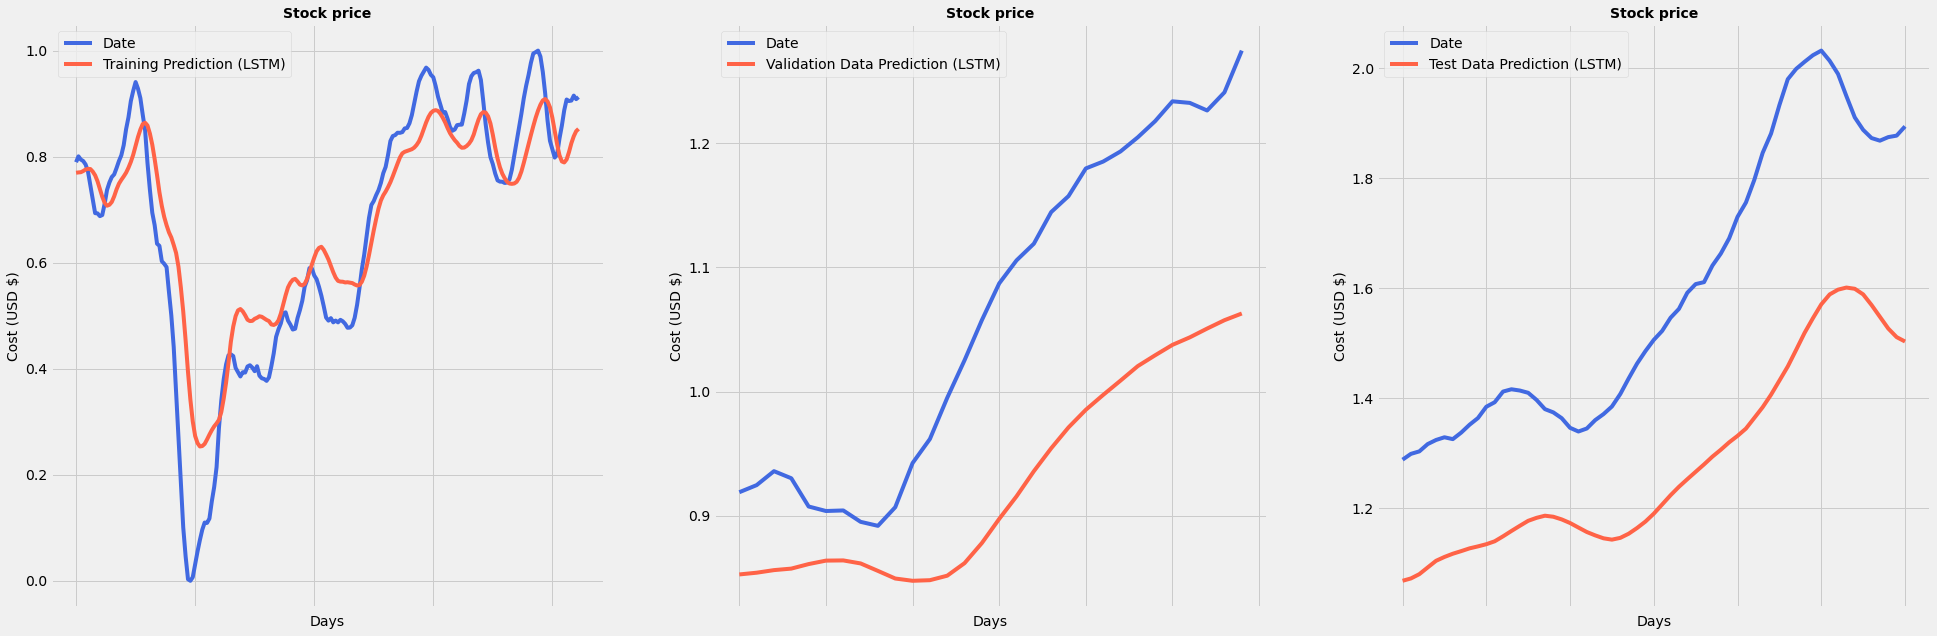

In [73]:
y_train_predict =model.predict(X_train)
y_val_predict =model.predict(X_val)
y_test_predict =model.predict(X_test)


plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict)

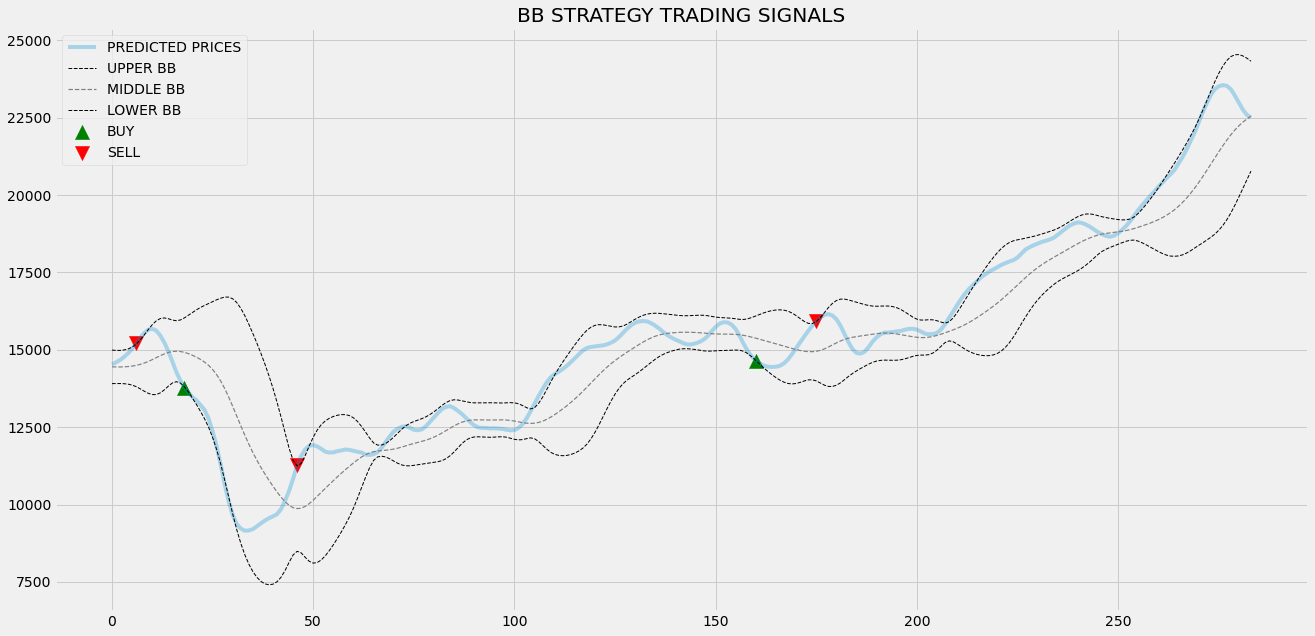

The actual returns had a value of 75.29% and the predicted returns had a value 54.2%


In [74]:
predictions=np.concatenate([y_train_predict, y_val_predict, y_test_predict])
pred_prices =scaler_inverse(train_array=train["y"].values,
                           predictions=predictions)
actuals = MPJ_df_featured["y"].values
bolling_df =get_bollinger_df(actuals, pred_prices, 20)

### Using South Korea -Dongkuk Stell Mill co Ltd(001230) dataset

In [75]:
DONG_df=pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx",7) [ :-1]
DONG_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,13650.0,13700.0,13750.0,13450.0,0.19K,0.0000
1,2021-03-30 00:00:00,13650.0,13850.0,14200.0,13050.0,3.17M,0.0074
2,2021-03-29 00:00:00,13550.0,12500.0,13800.0,12500.0,0.20K,0.1107
3,2021-03-28 00:00:00,12200.0,12200.0,12200.0,12200.0,-,0.0000
4,2021-03-26 00:00:00,12200.0,11500.0,12300.0,11350.0,2.34M,0.0796


In [76]:
DONG_df["Date"] = pd.to_datetime(DONG_df["Date"])
DONG_df.set_index("Date", inplace=True)
DONG_df =DONG_df[["Price"]]
DONG_df.columns=["price"]
DONG_df =DONG_df.sort_index()
DONG_df = DONG_df.rolling(7).mean().dropna()
DONG_df.head()

,price
Date,
2020-01-10,5655.714286
2020-01-13,5608.571429
2020-01-14,5552.857143
2020-01-15,5527.142857
2020-01-16,5502.857143


In [77]:
DONG_df_featured =Lookback_data(DONG_df,5)
DONG_df_featured.head()

,0,1,2,3,4,y
Date,,,,,,
2020-01-17,5655.714286,5608.571429,5552.857143,5527.142857,5502.857143,5511.428571
2020-01-20,5608.571429,5552.857143,5527.142857,5502.857143,5511.428571,5511.428571
2020-01-21,5552.857143,5527.142857,5502.857143,5511.428571,5511.428571,5505.714286
2020-01-22,5527.142857,5502.857143,5511.428571,5511.428571,5505.714286,5495.714286
2020-01-23,5502.857143,5511.428571,5511.428571,5505.714286,5495.714286,5488.571429


In [78]:
train_ratio=0.7
validation_ratio  =0.1

train_ratio +validation_ratio <= 0.8
train_size = int(len(DONG_df_featured) *+train_ratio)
val_size =int(len(DONG_df_featured) *validation_ratio)
test_size = len(DONG_df_featured) -train_size-val_size

train, val,  test = DONG_df_featured.iloc[0:train_size,:], DONG_df_featured.iloc[train_size: train_size + val_size,:]  ,\
        DONG_df_featured.iloc[train_size+val_size:len(DONG_df_featured),:]

In [79]:

scaler =MinMaxScaler(feature_range=(0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train[train.columns]))
val_scaled =pd.DataFrame(scaler.transform(val[val.columns]))
test_scaled =pd.DataFrame(scaler.transform(test[test.columns]))


train_scaled.columns =["day1","day2", "day3", "day4", "day5", "y"]
val_scaled.columns=["day1","day2", "day3", "day4", "day5", "y"]
test_scaled.columns = ["day1","day2", "day3", "day4", "day5", "y"]



## separting dataset into train, validation & test
# Training
X_train =train_scaled.drop("y", axis=1).values
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train =train_scaled["y"].values

# Validation
X_val =val_scaled.drop("y", axis=1).values
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val =val_scaled["y"].values

# Test
X_test =test_scaled.drop("y", axis=1).values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test =test_scaled["y"].values

In [80]:
model = Sequential()
model.add(LSTM(200,return_sequences=True,activation="relu", input_shape=(5,1)))
model.add(LSTM(200, return_sequences=True, activation="relu"))
model.add(LSTM(200))
model.add(Dense(1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 5, 200)            161600    
                                                                 
 lstm_22 (LSTM)              (None, 5, 200)            320800    
                                                                 
 lstm_23 (LSTM)              (None, 200)               320800    
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train , epochs=100, batch_size= 32, 
         validation_data = (X_val, y_val),
         callbacks=callbacks)

Epoch 1/100
7/8 [=========================>....] - ETA: 0s - loss: 0.2675
Epoch 1: val_loss did not improve from 0.00047
8/8 [==============================] - 3s 112ms/step - loss: 0.2626 - val_loss: 0.2081 - lr: 0.0010
Epoch 2/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0599
Epoch 2: val_loss did not improve from 0.00047
8/8 [==============================] - 0s 43ms/step - loss: 0.0589 - val_loss: 0.1697 - lr: 0.0010
Epoch 3/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0421
Epoch 3: val_loss did not improve from 0.00047
8/8 [==============================] - 0s 46ms/step - loss: 0.0422 - val_loss: 0.1101 - lr: 0.0010
Epoch 4/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0232
Epoch 4: val_loss did not improve from 0.00047
8/8 [==============================] - 0s 48ms/step - loss: 0.0232 - val_loss: 0.0207 - lr: 0.0010
Epoch 5/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0117
Epoch 5: val_loss did not improve from 0.0004

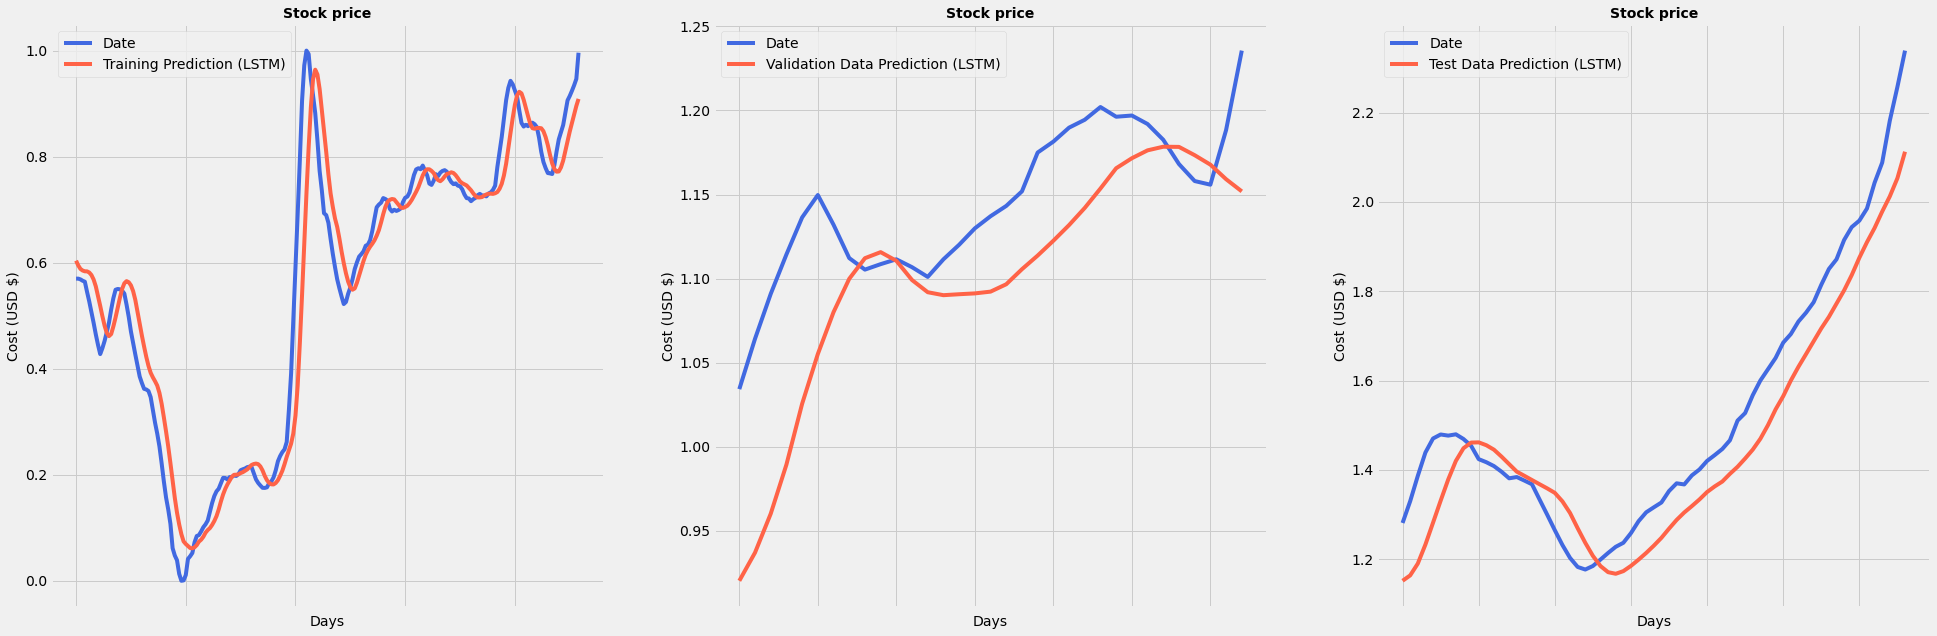

In [82]:
y_train_predict =model.predict(X_train)
y_val_predict =model.predict(X_val)
y_test_predict =model.predict(X_test)


plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict)

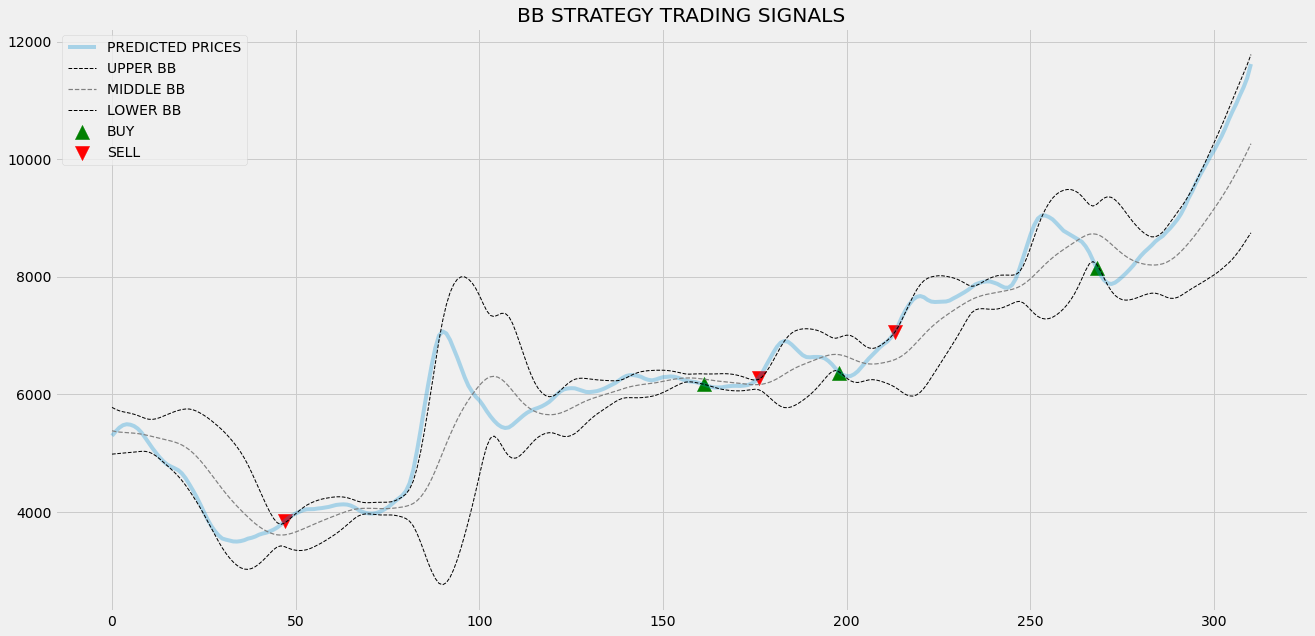

The actual returns had a value of 130.41% and the predicted returns had a value 116.35%


In [83]:
predictions=np.concatenate([y_train_predict, y_val_predict, y_test_predict])
pred_prices =scaler_inverse(train_array=train["y"].values,
                           predictions=predictions)
actuals = DONG_df_featured["y"].values
bolling_df =get_bollinger_df(actuals, pred_prices, 20)